In [1]:
%cd ..

/home/dani2442/Projects/TrafficFlow


/home/dani2442/Projects/TrafficFlow/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import networkx as nx

In [3]:
V_0 = 50 # Desired speed (km/h)
T = 1.2/3600 # Time gap (h)
rho_max = 120 # Maximum density (veh/km)

l_eff = 1/rho_max # Inverse of the minimum distance headway
rho_C = 1/(V_0*T + l_eff) # Critical value between free traffic and congested traffic
C = 1/(T + l_eff/V_0)

@jax.jit
def Q_e(rho):
    return jnp.maximum(0, jnp.where(rho<=rho_C, V_0*rho, (1-rho*l_eff)/T))

In [4]:
x_0, x_N = 0, 100
N_x = 11
T_sim = 4
N_t = 1000
I = 1.0

dx = (x_N - x_0)/(N_x)
dt = T_sim/N_t

In [155]:
def generate_continuous():
    I = jnp.eye(N_x+1, k=1)
    I = I.at[int(N_x/1.5), int(N_x/1.5)+1].set(0.01)
    I = I.at[int(N_x/1.5)+1, int(N_x/1.5)+2].set(0.01)
    rho = jnp.eye(N_x+1, k=1)*rho_max/4
    A = jnp.eye(N_x+1, k=1)
    return rho, A, I

In [165]:
def plot_graph(rho, A, I, ax, title=''):
    G = nx.DiGraph()
    n = rho.shape[0]
    G.add_nodes_from([i for i in range(n)])
    A_b = jnp.isclose(A, 0, rtol=1e-5)
    G.add_weighted_edges_from([(j,i, rho[j,i]) for j, v_j in enumerate(A_b) for i in range(n) if not v_j[i]])

    pos = nx.planar_layout(G)
    weights = [float(G.edges[e]['weight']) for e in G.edges()]
    # Normalize the weights for colormap
    #norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    norm = plt.Normalize(0, 120)

    ax.set_title(title)
    # Create the colormap
    cmap = plt.cm.viridis
    nx.draw_networkx_edges(G, pos, node_size=0, arrowstyle='->', width=5, edge_color=weights, edge_cmap=cmap, ax=ax, edge_vmin = 0, edge_vmax=120)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, ax=ax)

In [166]:
rho, A, I = generate_continuous()
rho.shape

(12, 12)

[]

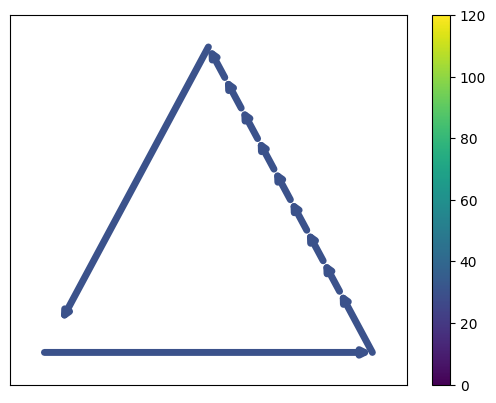

In [167]:
fig, ax = plt.subplots()
plot_graph(rho, A, I, ax)
plt.plot()

In [168]:
rho, A, I = generate_continuous()
n = A.shape[0]
flux = jnp.where(jnp.isclose(I, 0), 0, I*Q_e(rho/I))
f_0 = jnp.sum(flux, axis=0)
f_1 = jnp.sum(flux, axis=1)
mask = jnp.logical_not(jnp.isclose(jnp.outer(jnp.sum(A, axis=0), jnp.sum(A, axis=1))*A,0))
u = jnp.outer(f_0, jnp.ones(n))*mask
w = jnp.outer(jnp.ones(n), f_1)*mask
v = flux*mask

rho_0 = jnp.sum(rho, axis=0)
rho_1 = jnp.sum(rho, axis=1)
u_local = jnp.outer(rho_0, jnp.ones(n))
w_local = jnp.outer(jnp.ones(n), rho_1)
v_local = rho

d_inv = jnp.pow(jnp.sum(A, axis=1), -1)
D_inv = jnp.diag(jnp.where(jnp.isinf(d_inv), 0, d_inv))
u = jnp.dot(D_inv, u)
u_local = jnp.dot(D_inv, u_local)

mi1 = jnp.minimum(u, v)
ma1 = jnp.maximum(u, v)
Q_up = jnp.where(u_local<=v_local, mi1, ma1)

mi2 = jnp.minimum(v, w)
ma2 = jnp.maximum(v, w)
Q_down = jnp.where(v_local<=w_local, mi2, ma2)

rho = rho - dt/dx*(Q_down - Q_up)

In [169]:
@jax.jit
def CTM_step(rho, A, I, verbose=False):
    n = A.shape[0]
    flux = jnp.where(jnp.isclose(I, 0), 0, I*Q_e(rho/I))
    f_0 = jnp.sum(flux, axis=0)
    f_1 = jnp.sum(flux, axis=1)
    mask = jnp.logical_not(jnp.isclose(jnp.outer(jnp.sum(A, axis=0), jnp.sum(A, axis=1))*A,0))
    u = jnp.outer(f_0, jnp.ones(n))*mask
    w = jnp.outer(jnp.ones(n), f_1)*mask
    v = flux*mask

    rho_0 = jnp.sum(rho, axis=0)
    rho_1 = jnp.sum(rho, axis=1)
    u_local = jnp.outer(rho_0, jnp.ones(n))
    w_local = jnp.outer(jnp.ones(n), rho_1)
    v_local = rho

    d_inv = jnp.pow(jnp.sum(A, axis=1), -1)
    D_inv = jnp.diag(jnp.where(jnp.isinf(d_inv), 0, d_inv))
    u = jnp.dot(D_inv, u)
    u_local = jnp.dot(D_inv, u_local)

    mi1 = jnp.minimum(u, v)
    ma1 = jnp.maximum(u, v)
    Q_up = jnp.where(u_local<=v_local, mi1, ma1)

    mi2 = jnp.minimum(v, w)
    ma2 = jnp.maximum(v, w)
    Q_down = jnp.where(v_local<=w_local, mi2, ma2)

    return rho - dt/dx*(Q_down - Q_up)

In [170]:
CTM_step(rho, A, I)

Array([[ 0.     , 30.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     , 30.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , 30.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     , 30.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     , 30.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        30.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     , 30.64548,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.

[]

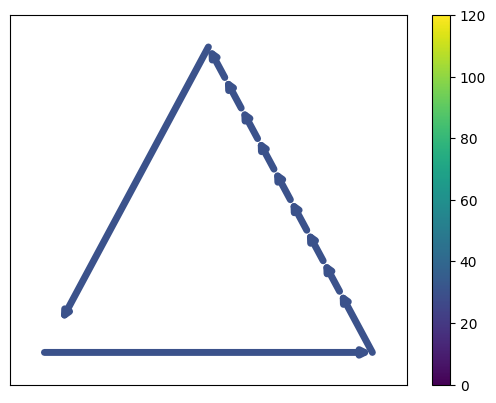

In [171]:
rho, A, I = generate_continuous()

fig, ax = plt.subplots()
plot_graph(rho, A, I, ax)
plt.plot()

In [172]:
rho, A, I = generate_continuous()
G_checkpoints = []

for t_i in range(N_t+1):
    rho = CTM_step(rho, A, I)
    if t_i%200 == 0:
        G_checkpoints += [rho.copy()]

[]

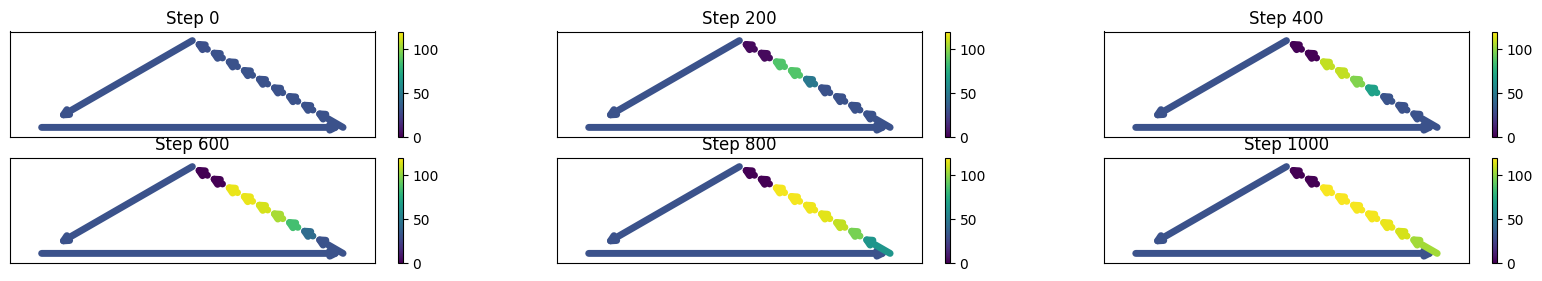

In [173]:
f, axs = plt.subplots(2, len(G_checkpoints)//2, figsize=(20,3))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], A, I, ax=ax, title=f'Step {i*200}')

plt.plot()

In [14]:
G, pos = generate_converge()
G = init_converge(G)

fig, ax = plt.subplots()
plot_graph(G, pos, ax, '')
plt.plot()

NameError: name 'generate_converge' is not defined

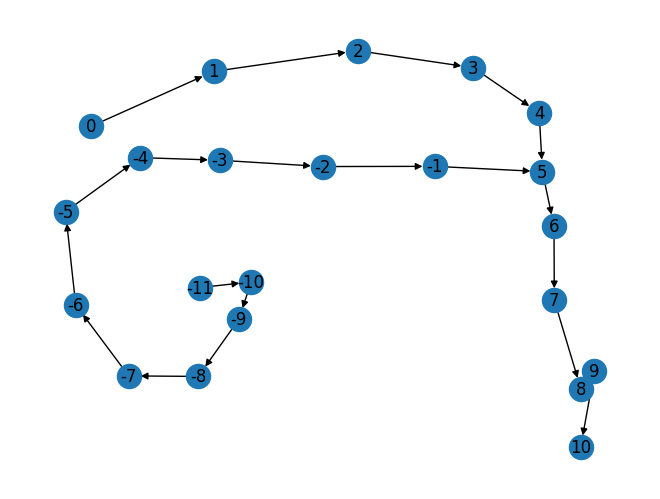

In [ ]:
nx.draw(G, pos=nx.spring_layout(G), with_labels=True)

In [ ]:
G = init_converge(G)
G_checkpoints = []

for t_i in range(N_t):
    G = CTM_step(G)
    if t_i%50 == 0:
        G_checkpoints += [G.copy()]

[]

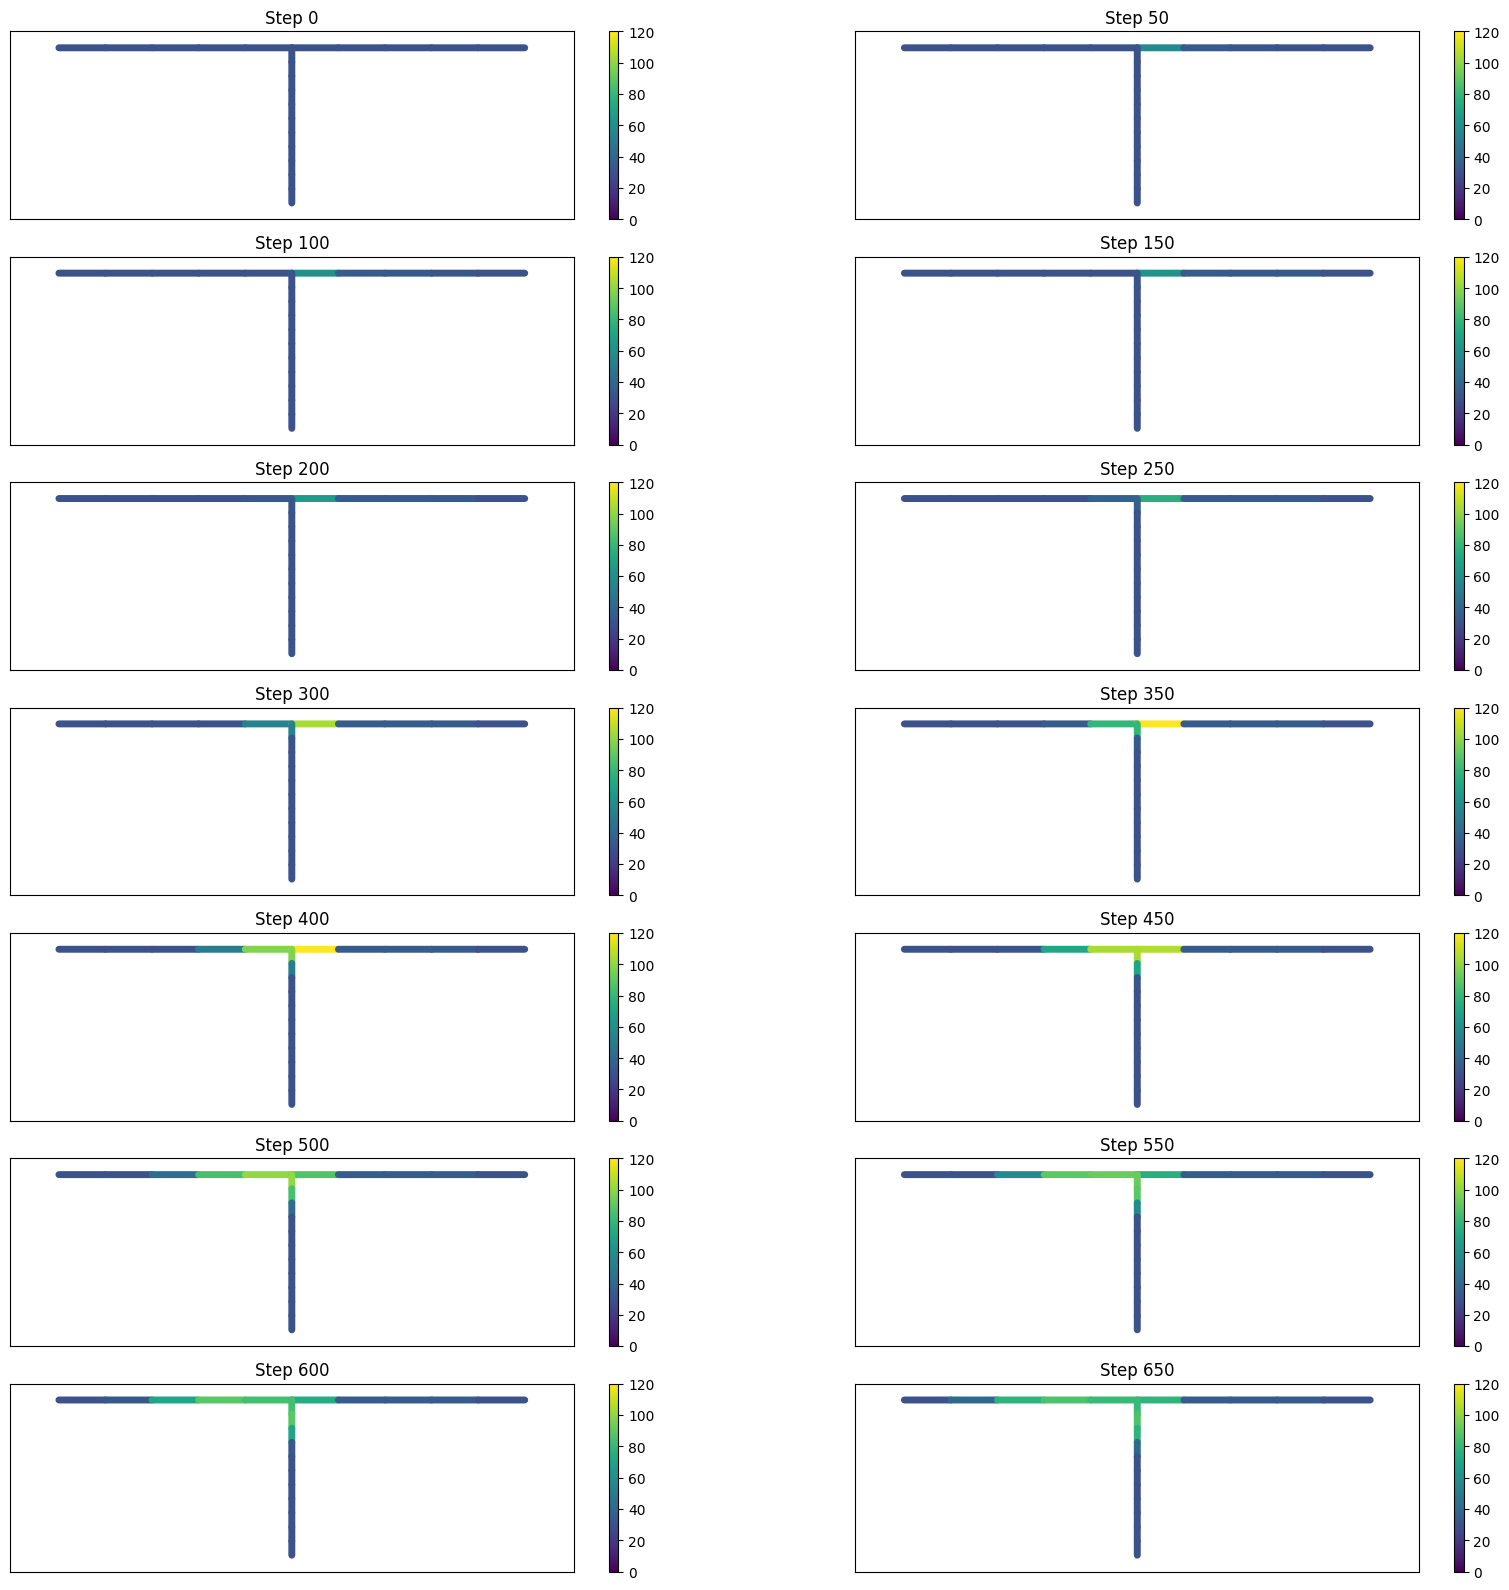

In [ ]:
f, axs = plt.subplots(7, 2, figsize=(20,20))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], pos=pos, ax=ax, title=f'Step {i*50}')

plt.plot()

# 1. Diverging

In [ ]:
""" G = nx.DiGraph()

G.add_nodes_from([0,1,2,3,4,5])
G.add_edges_from([(0,1), (1,2), (2, 3), (3, 4), (2, 5), (5, 6)])

pos = {0: (0,0), 1:(1, 0), 2: (2,0), 3: (3, 1), 4: (4, 2), 5: (3,-1), 6: (4, -2)}

nx.draw(G, pos, with_labels=True, font_weight='bold') """

" G = nx.DiGraph()\n\nG.add_nodes_from([0,1,2,3,4,5])\nG.add_edges_from([(0,1), (1,2), (2, 3), (3, 4), (2, 5), (5, 6)])\n\npos = {0: (0,0), 1:(1, 0), 2: (2,0), 3: (3, 1), 4: (4, 2), 5: (3,-1), 6: (4, -2)}\n\nnx.draw(G, pos, with_labels=True, font_weight='bold') "

[]

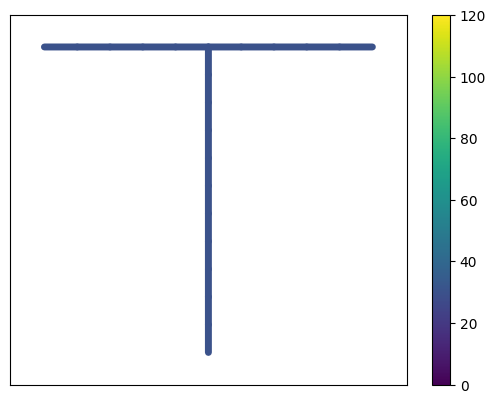

In [ ]:
G, pos = generate_diverge()
G = init_converge(G)

fig, ax = plt.subplots()
plot_graph(G, pos, ax, '')
plt.plot()

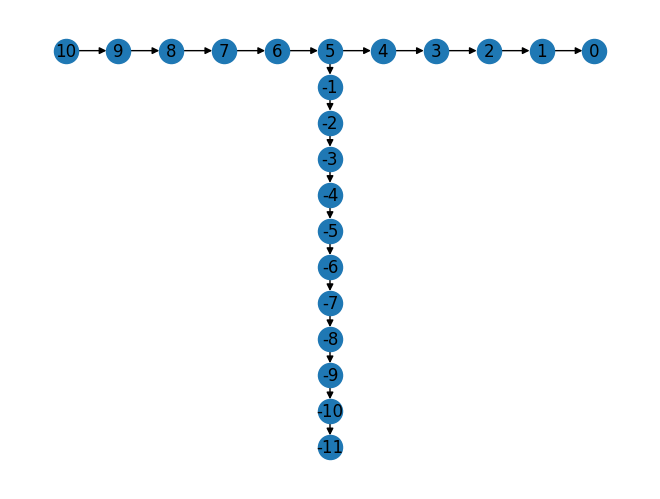

In [ ]:
nx.draw(G, pos=pos, with_labels=True)

In [ ]:
G = init_converge(G)
G_checkpoints = []

for t_i in range(N_t):
    G = CTM_step(G)
    if t_i%50 == 0:
        G_checkpoints += [G.copy()]

[]

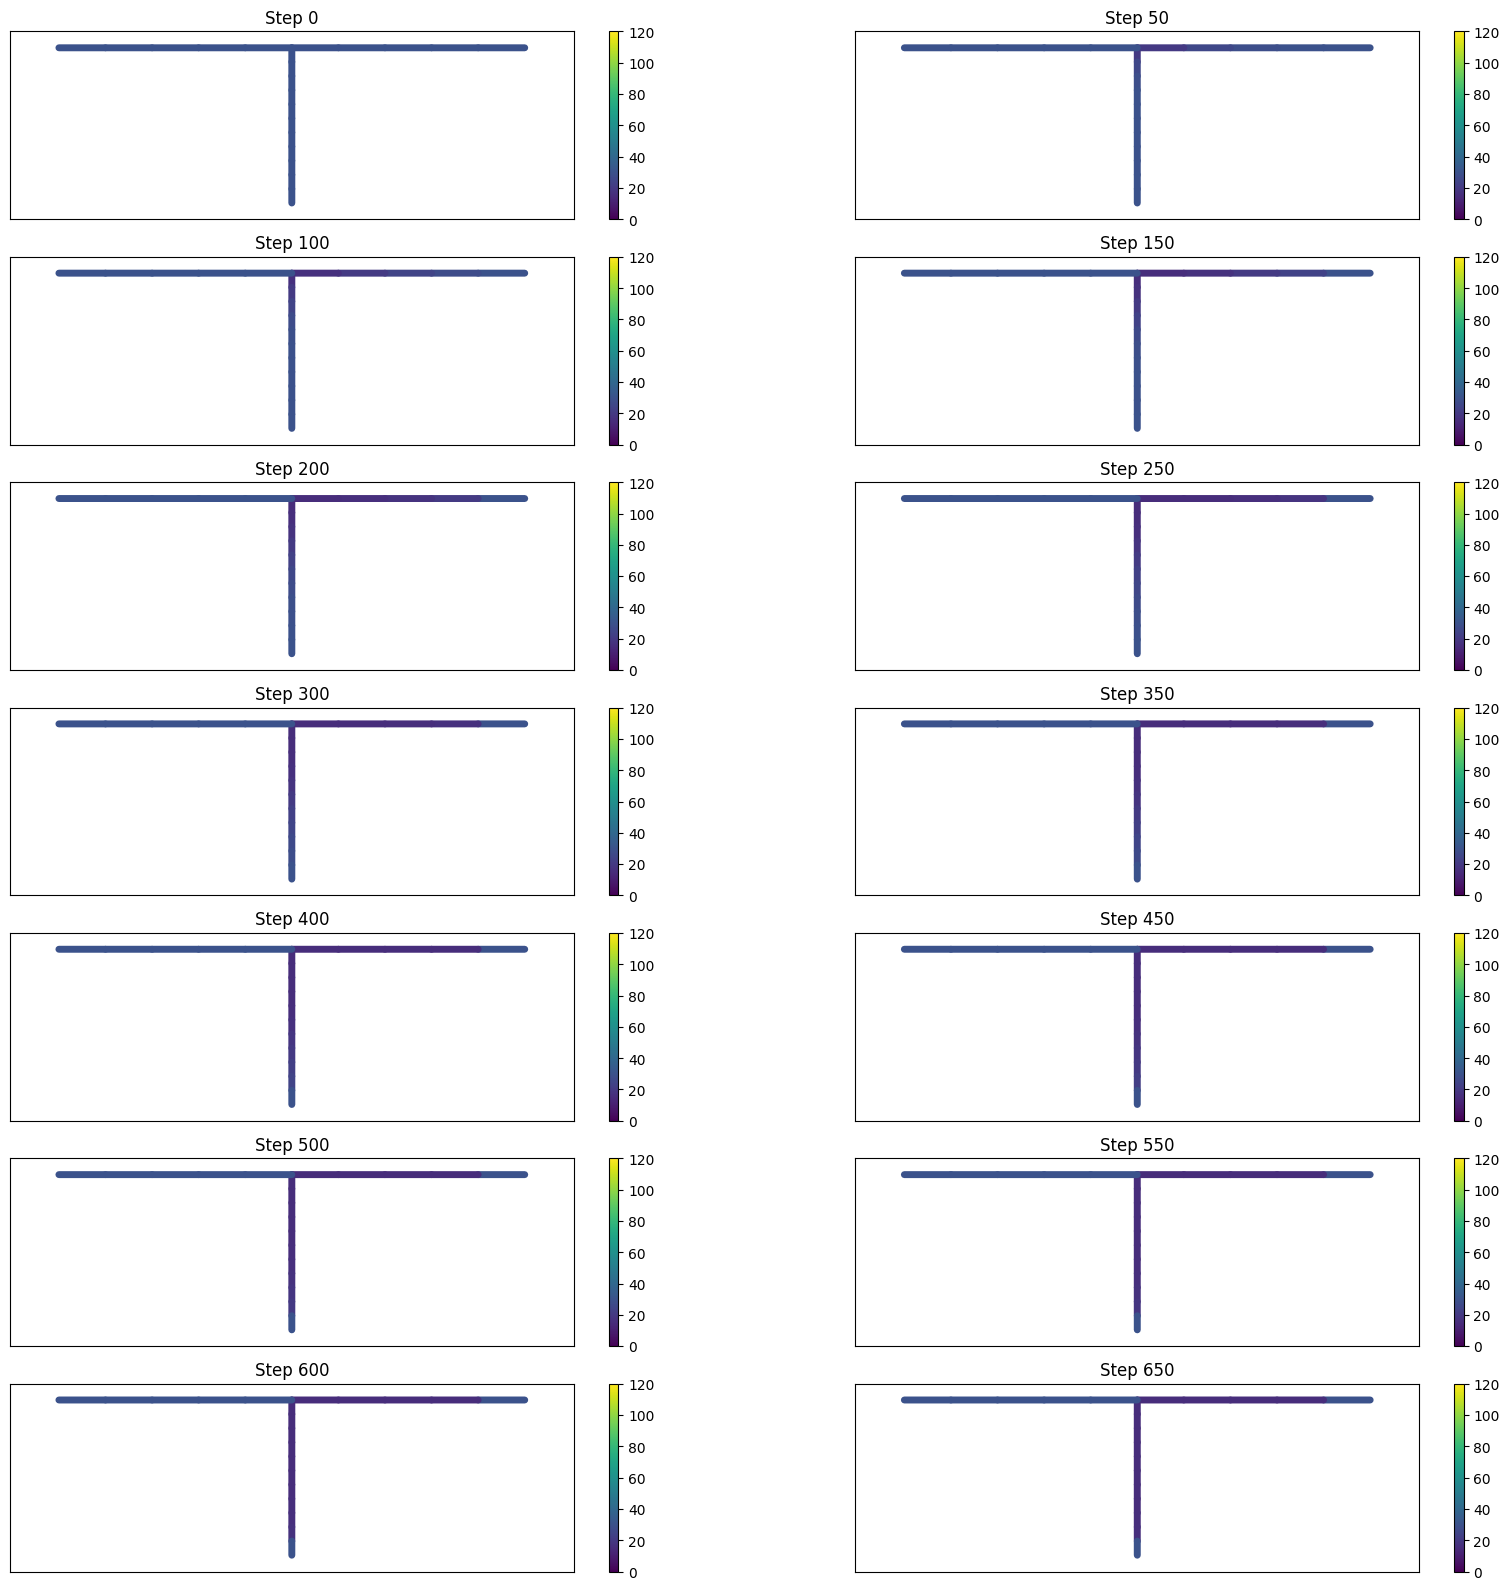

In [ ]:
f, axs = plt.subplots(7, 2, figsize=(20,20))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], pos=pos, ax=ax, title=f'Step {i*50}')

plt.plot()